## Investigating Automation of Absorption Line Masking

### Code initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import lmfit
from tqdm import tqdm
from utils import plot_multi_dep, plot_multi_ind

In [2]:
plt.rcParams.update({'font.size': 18})

In [3]:
files = glob.glob('./data/*.fits')
filename = files[0]
f = fits.open(filename)
flux = f[1].data['flux']
lmbd = 10**f[1].data['loglam']
ivar = f[1].data['ivar']

In [4]:
ldx, rdx = np.searchsorted(lmbd, (4000, 9000))
lmbd = lmbd[ldx:rdx]
flux = flux[ldx:rdx]
ivar = ivar[ldx:rdx]

In [5]:
def residual(params, x, data, ivar):
    return (data-model(x, params['coeff'], params['temp']))*np.sqrt(ivar)

def model(x, coeff, temp):
    return coeff/(x**5 * np.expm1(1.4394e-2/x/temp))

def fit(idx=np.arange(len(lmbd)), lmbd=lmbd, flux=flux, ivar=ivar):
    x = lmbd[idx]/1e10
    y = flux[idx]
    v = ivar[idx]
    out = lmfit.minimize(residual, params, args=(x, y, v))
    vals = out.params
    vals = {'coeff': vals['coeff'].value, 'temp': vals['temp'].value}
    return vals, out.redchi

def plot_fit(y_expc, idx=np.arange(len(lmbd)), title=None, x=lmbd, y=flux):
    plot_multi_dep(x, (y, y_expc), yfmts=('k', 'r'), ynames=('data', 'model'), title=title, legend=True)
    
def plot_one(y, x=lmbd, ylim=None, title=None):
    plot_multi_dep(x, (y,), yfmts=('k',), ylim=ylim, title=title)

params = lmfit.Parameters()
params.add('coeff', value=1e-22)
params.add('temp', value=1e5, min=1e3, max=1e8)

### Initial fit for model
Start by fitting the entire curve without regard to the absorption lines.

In [6]:
vals, redchi = fit()
print(f'coeff: {vals["coeff"]}\ttemp: {vals["temp"]}\nred chi^2: {redchi}')

coeff: 1.365883406074533e-29	temp: 12976.60478576338
red chi^2: 43.940070134943184


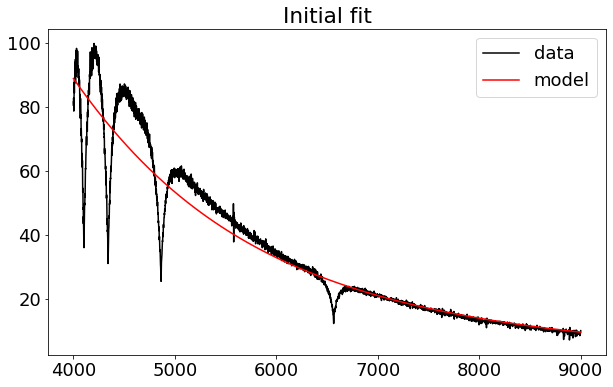

In [7]:
y_expc = model(lmbd/1e10, vals['coeff'], vals['temp'])
plot_fit(y_expc, title='Initial fit')

As expected, the curve is too low on the left side of the spectrum due to the dips.

### Compute points to exclude

Quantify how poor the fit is at any given point using residuals and the variance of the normalized curve.

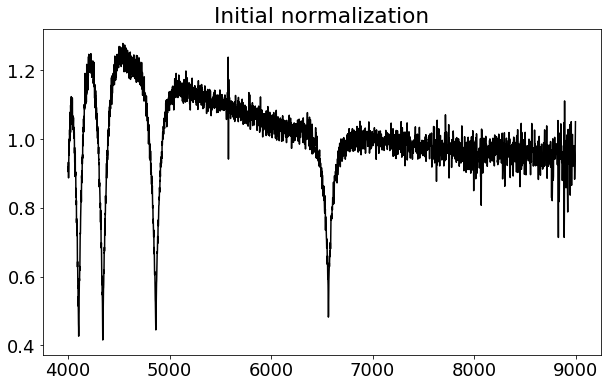

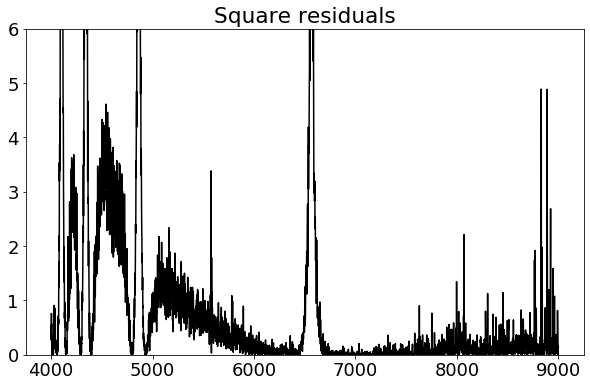

In [8]:
y_norm = flux/y_expc
var = np.var(y_norm)
rsq = (1-y_norm)**2/var

plot_one(y_norm, title='Initial normalization')
plot_one(rsq, ylim=(0, 6), title='Square residuals')

Note that for the areas surrounding the absorption lines, a massive spike in the residual (squared) is observed. To avoid cutting out natural fluctuations, evaluate the mean variance over a fixed window size. If the mean variance within a given window is above some threshold, exclude the entire window. This also helps with avoiding ambiguity of where the absorption line begins and ends.

In [9]:
def crop_fit(resid, thresh, lmbd=lmbd, flux=flux, ivar=ivar, window=111, step=10):
    exclude = set()
    
    for i in range(0, (len(lmbd)-window+1)//step):
        ldx = i * step
        rdx = ldx + window - 1
        mean_resid = np.mean(resid[ldx:rdx])
        
        if mean_resid > thresh:
            exclude.update(np.arange(ldx, rdx))
    
    exclude = list(exclude)
    include = np.arange(len(lmbd))
    idx_msk = np.logical_not(np.in1d(include, exclude))
    include = include[np.argwhere(idx_msk)]
    
    vals, chi = fit(include)
    vals['chi'] = chi
    return (include, exclude), vals

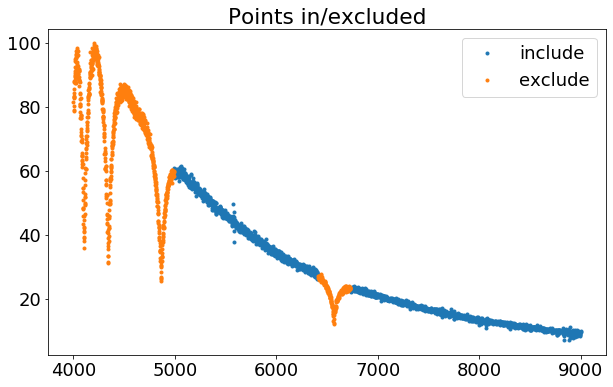

In [10]:
(inc_sq, exc_sq), out_sq = crop_fit(rsq, 1.5)

plot_multi_ind((lmbd[inc_sq], lmbd[exc_sq]),
               (flux[inc_sq], flux[exc_sq]),
               fmts=('.', '.'),
               names=('include', 'exclude'),
               title='Points in/excluded',
               legend=True)

### Updated fit
After excluding the points with high variance, the remaining parts of the curve ought to be the smooth sections. Fit the curve to these cropped regions.

coeff: 7.424511420772944e-30	temp: 18140.313416178382
red chi^2: 0.8512856860871011


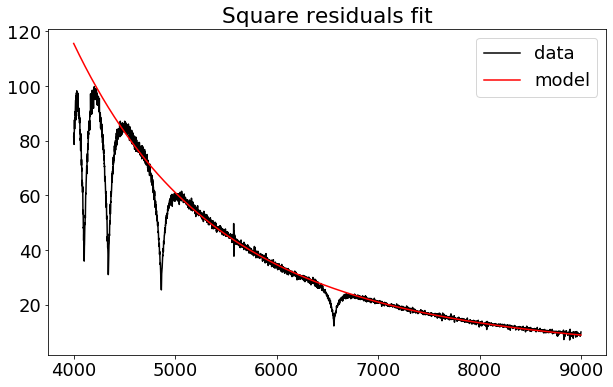

In [11]:
y_sq_expc = model(lmbd/1e10, out_sq['coeff'], out_sq['temp'])

print(f'coeff: {out_sq["coeff"]}\ttemp: {out_sq["temp"]}\nred chi^2: {out_sq["chi"]}')
plot_fit(y_sq_expc, title='Square residuals fit')

As can be seen, after a single iteration, the curve is already very well fit.

### Alternative computation of exclusion

Below, an alternative method of computing the "poorness of fit" is considered. Specifically, we now take the exponential of the residuals instead of the squares.

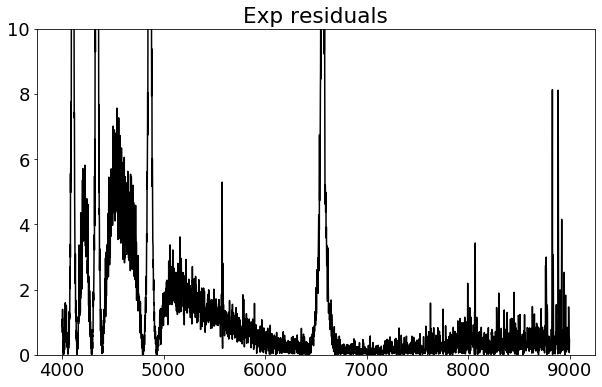

In [12]:
rxp = np.expm1(np.sqrt((1-y_norm)**2/var))
plot_one(rxp, ylim=(0, 10), title='Exp residuals')

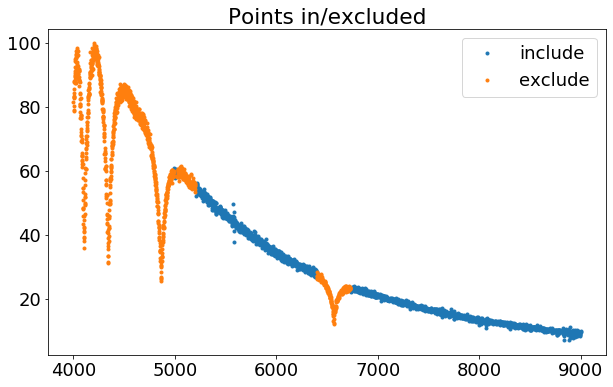

In [13]:
(inc_xp, exc_xp), out_xp = crop_fit(rxp, 2)

plot_multi_ind((lmbd[inc_xp], lmbd[exc_xp]),
               (flux[inc_xp], flux[exc_xp]),
               fmts=('.', '.'),
               names=('include', 'exclude'),
               title='Points in/excluded',
               legend=True)

coeff: 7.549462388430877e-30	temp: 17963.10770390565
red chi^2: 0.8286796116937786


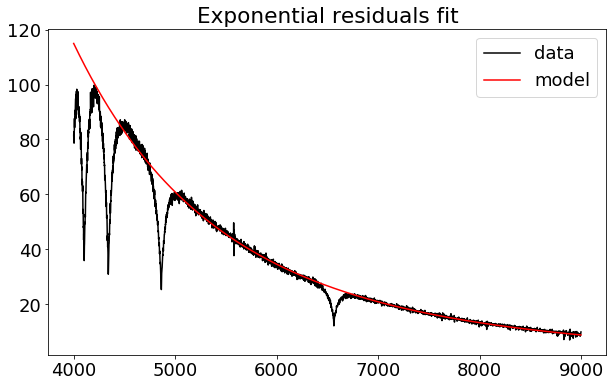

In [14]:
y_xp_expc = model(lmbd/1e10, out_xp['coeff'], out_xp['temp'])

print(f'coeff: {out_xp["coeff"]}\ttemp: {out_xp["temp"]}\nred chi^2: {out_xp["chi"]}')
plot_fit(y_xp_expc, title='Exponential residuals fit')

With the appropriate window-mean-residual threshold, this fit obtains results nearly identical to the squares fit.

### Identifying a good threshold

Below, we experiment with various values for the window-mean-threshold.

In [15]:
def find_thresh(resid, init_thresh=0, last_thresh=5, incr_thresh=0.01):
    thresh = np.linspace(init_thresh, last_thresh, num=int((last_thresh-init_thresh)//incr_thresh+1))
    redchi = []
    
    for t in tqdm(thresh):
        i, vals = crop_fit(resid, thresh=t)
        redchi.append(vals['chi'])
    
    return thresh, redchi

In [16]:
t, c = find_thresh(rsq)

100%|██████████| 500/500 [00:08<00:00, 62.20it/s]


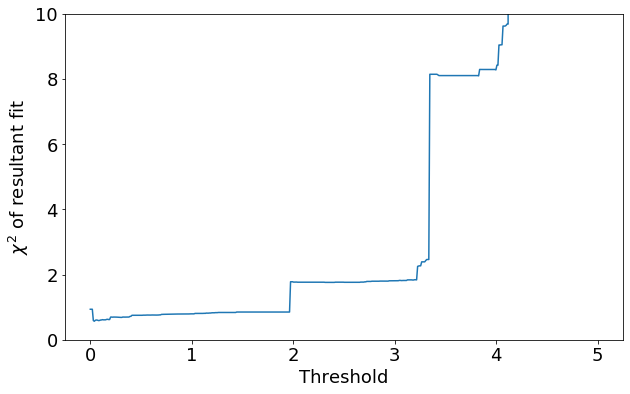

In [17]:
plt.figure(figsize=(10,6))
plt.ylim((0, 10))
plt.xlabel('Threshold')
plt.ylabel('$\chi^2$ of resultant fit')
plt.plot(t, c)
plt.show()

On the right side of the graph, unsurprisingly, the higher the threshold, the worse the fit becomes, since more sections of the absorption lines are allowed to drag the model's curve down.

It was found that the left side of the graph has very low $\chi^2$ values because so many points are cropped out that the resultant model naturally overfits. Possible ways to penalize this behaviour include rewarding total number of data points left in (with less weighting than the $\chi^2$ itself) or optimizing this function to approach a $\chi^2$ value of $1$.

The step-ladder appearance of the graph arises from the fact that many of the sections of the absorption lines have nearly identical window-mean-residuals. Then, immediately after the threshold crosses this value, many windows are included simultaneously, with an immediately obvious impact on the curve.

### Other possible experiments
The values of the window and step size were empirically and somewhat arbitrarily chosen (window size was chosen as roughly half  the total width of the absorption lines, and step size was simply chosen for computational efficiency). These values may not be optimal, nor transferable to other spectra. However, it is possible to do similar experiments as shown above for the threshold.

Also, the method used to compute the "poorness of fit" is somewhat arbitrary. The square and exponential functions were merely two functions capable of dramatically increasing the difference between large and small residuals, which is desirable specifically for the window-mean-residual calculation. There may be other low-cost computation functions that can achieve better results, though not investigated here.